## Question 3

In [8]:
import numpy as np
import scipy as scipy
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz
from scipy.sparse import csr_matrix, kron
def blur(N, band=3, sigma=0.7):
    z = np.block([np.exp(-(np.array([range(band)])**2)/(2*sigma**2)), np.zeros((1, N-band))])
    A = toeplitz(z)
    A = csr_matrix(A)
    A = (1/(2*scipy.pi*sigma**2))*kron(A,A)
    
    x = np.zeros((N, N))
    N2 = round(N/2)
    N3 = round(N/3)
    N6 = round(N/6)
    N12 = round(N/12)
    
    # Large elipse
    T = np.zeros((N6, N3))
    for i in range(1, N6+1):
        for j in range(1, N3+1):
            if (i/N6)**2 + (j/N3)**2 < 1:
                T[i-1,j-1] = 1
    
    T = np.block([np.fliplr(T), T])
    T = np.block([[np.flipud(T)],[T]])
    x[2:2+2*N6, N3-1:3*N3-1] =  T
    
    # Small elipse
    T = np.zeros((N6, N3))
    for i in range(1, N6+1):
        for j in range(1, N3+1):
            if (i/N6)**2 + (j/N3)**2 < 0.6:
                T[i-1,j-1] = 1
    
    T = np.block([np.fliplr(T), T])
    T = np.block([[np.flipud(T)],[T]])
    x[N6:3*N6, N3-1:3*N3-1] =  x[N6:3*N6, N3-1:3*N3-1] + 2*T
    x[x==3] = 2*np.ones((x[x==3]).shape)
    
    T = np.triu(np.ones((N3,N3)))
    mT, nT = T.shape
    x[N3+N12:N3+N12+nT,1:mT+1] = 3*T
    
    T = np.zeros((2*N6+1,2*N6+1))
    mT, nT = T.shape
    T[N6,:] = np.ones((1,nT))
    T[:,N6] = np.ones((mT))
    x[N2+N12:N2+N12+mT,N2:N2+nT] = 4*T
    
    x = x[:N,:N].reshape(N**2,1)
    b = A @ x
    
    return A, b, x

In [9]:
def generic_grad(f, gf, lsearch, x0, eps):
    from time import time
    x_k = x0
    i = 0
    fs = [f(x0)]
    ts = []  
    start = time()
    while True:
        if i == 1:
            print("i == 1")
            plt.figure(figsize=(6, 6))
            plt.imshow(x_k.reshape(128, 128), cmap='gray')
            plt.show()
        if i == 10:
            print("i == 10")
            plt.figure(figsize=(6, 6))
            plt.imshow(x_k.reshape(128, 128), cmap='gray')
            plt.show()
        if i == 100:
            print("i == 100")
            plt.figure(figsize=(6, 6))
            plt.imshow(x_k.reshape(128, 128), cmap='gray')
            plt.show()
        if i == 1000:
            print("i == 1000")
            plt.figure(figsize=(6, 6))
            plt.imshow(x_k.reshape(128, 128), cmap='gray')
            plt.show()
            break

        t = lsearch(f, x_k, gf(x_k))
        x_k_1 = x_k - t * gf(x_k)
        fs.append(f(x_k_1))
        ts.append(time()-start)
        if abs(f(x_k) - f(x_k_1)) <= eps:
            break
        x_k = x_k_1
        i += 1
    return x_k_1, fs, ts 

In [10]:
def exact_quad(A):
    def inner_func(f, xk, gk):
        return 0.5 * ((np.linalg.norm(gk) / np.linalg.norm(A @ gk)) ** 2)

    return inner_func

In [11]:
def const_step(s):
    if s <= 0:
        raise ValueError("S should be positive.")

    def inner_func(f, xk, gk):
        return s

    return inner_func

In [12]:
A,b,x = blur(128,5,1)

#### 2.1)

i == 1


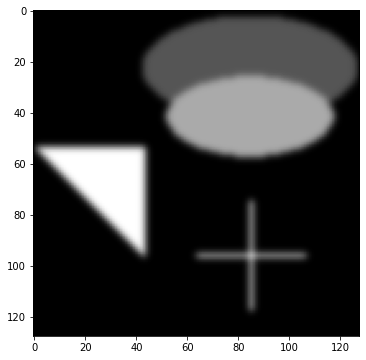

i == 10


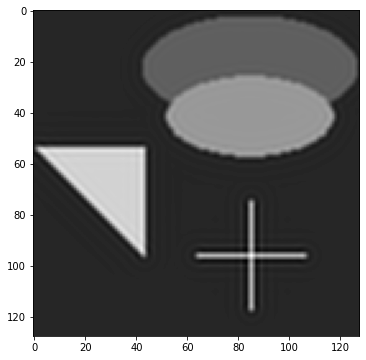

i == 100


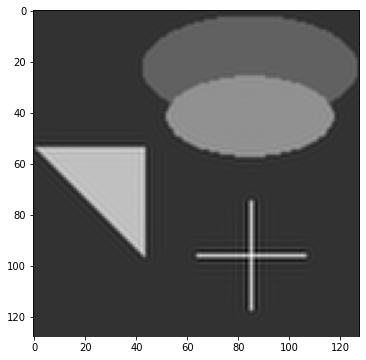

i == 1000


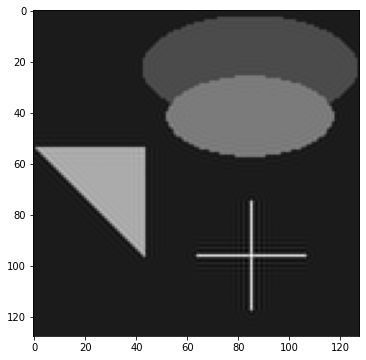

In [13]:
AtA = A.T @ A

f = lambda x: np.linalg.norm(A @ x - b) ** 2
gf = lambda x: 2 * ( AtA @ x- A.T @ b)
x_1, fs_1, ts_1 = generic_grad(f,gf, exact_quad(AtA),np.zeros((16384, 1)), 10 ** -6)

In [14]:
import scipy.sparse.linalg as LA
eigenvalue = max(LA.eigs(AtA, which='LR', return_eigenvectors=False))
eigenvalue = np.real(eigenvalue)

i == 1


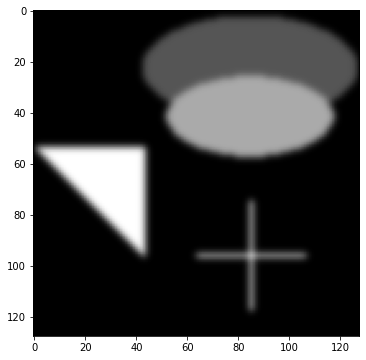

i == 10


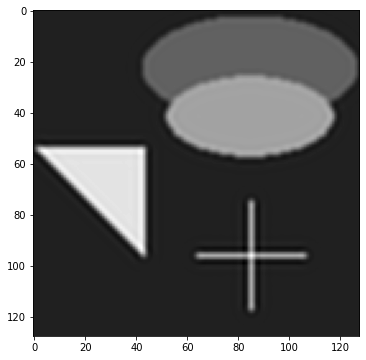

i == 100


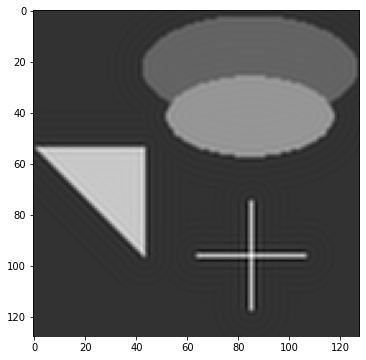

i == 1000


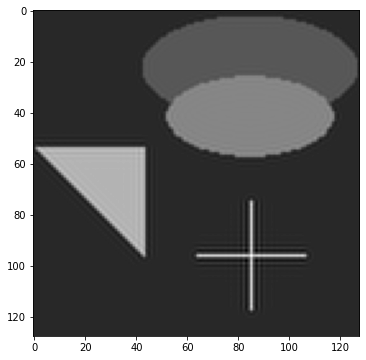

In [15]:
x_1, fs_1, ts_1 = generic_grad(f, gf, const_step(1/(2*eigenvalue)), np.zeros((16384, 1)), 10 ** -6)

Both methods run at approximalty the same time, it appears that the constant method runs a bit faster.<br>
It would seem that the exact method produces more accurate approximations.

#### 3.3)

In [16]:
def fista(f, gf, L, x0, iterations):
    from time import time
    fs = [f(x0)]
    gs = [np.linalg.norm(gf(x0))]
    ts = []
    y_k = x0
    t = 1
    x_k = x0
    start = time()
    while iterations >= 0:
        if iterations == 999:
            print("i == 1")
            plt.figure(figsize=(6, 6))
            plt.imshow(x_k.reshape(128, 128), cmap='gray')
            plt.show()
        if iterations == 100:
            print("i == 10")
            plt.figure(figsize=(6, 6))
            plt.imshow(x_k.reshape(128, 128), cmap='gray')
            plt.show()
        if iterations == 10:
            print("i == 100")
            plt.figure(figsize=(6, 6))
            plt.imshow(x_k.reshape(128, 128), cmap='gray')
            plt.show()
        if iterations == 1:
            print("i == 1000")
            plt.figure(figsize=(6, 6))
            plt.imshow(x_k.reshape(128, 128), cmap='gray')
            plt.show()
            break
        x_k_1 = y_k - L * gf(y_k)
        t_k_1 = (1 + (1 + 4 * (t ** 2)) ** 0.5)/2
        y_k = x_k_1 + ((t-1)/t_k_1)*(x_k_1 - x_k)
        x_k = x_k_1
        t = t_k_1
        iterations -= 1
        fs.append(f(x_k_1))
        gs.append(np.linalg.norm(gf(x_k_1)))
        ts.append(time()-start)
    return x_k_1, fs, gs, ts

#### 3.4)

i == 1


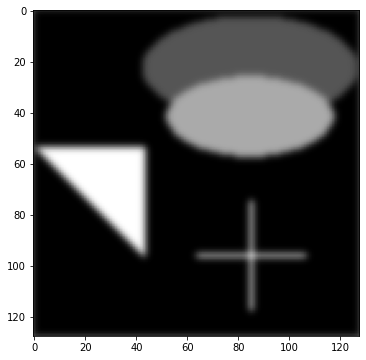

i == 10


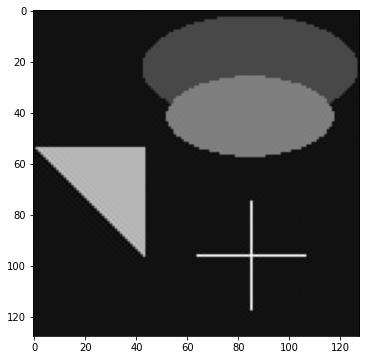

i == 100


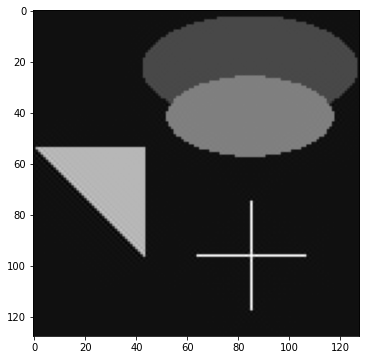

i == 1000


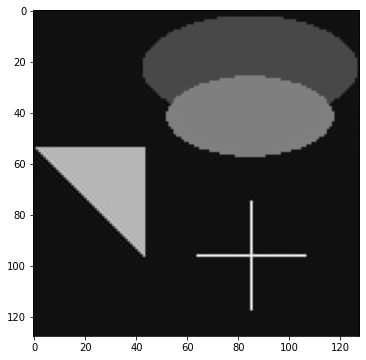

In [17]:
x_2,fs_2,_, ts_2 = fista(f, gf,1/(2*eigenvalue) , np.ones((16384, 1)), 1000)

The FISTA method runs at the same time as the other methods, the FISTA method also produces the most accurate approximations.

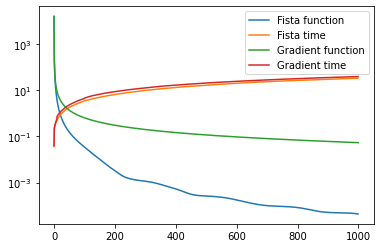

In [18]:
plt.semilogy(fs_2, label="Fista function")
plt.semilogy(ts_2, label="Fista time")
plt.semilogy(fs_1, label="Gradient function")
plt.semilogy(ts_1, label="Gradient time")
plt.legend()
plt.show()